In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, utils, svm
import seaborn as sns
le = preprocessing.LabelEncoder()

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2


In [3]:
def kmeans_cluster(sdf1):
    distortions = []
    K = range(1,10)
    for k in K:
        kmeanModel = KMeans(n_clusters=k).fit(sdf1)
        #kmeanModel.fit(sdf1)
        distortions.append(sum(np.min(cdist(sdf1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / sdf1.shape[0])

    # Plot the elbow
    plt.plot(K, distortions, 'b*-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
    #print(distortions)
    return 

def scale_to_ten(old_value):
    old_min = min(old_value)
    old_max = max(old_value)
    new_min = 0
    new_max = 10

    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
    return new_value

#scale_to_ten(min(df1['score']),max(df1['score']),df1['score'])

def mape(y_true,y_pred):
    res = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return res

def mpe(y_true,y_pred):
    res =- np.mean((y_true - y_pred) / y_true)*100
    return res

In [4]:
df = pd.read_csv('triproute.csv')
df.head()

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc
0,1,1.633,0.43.37,30.494434,0,22676.0,0,118,184,4,1
1,2,0.284,0.14.10,18.058823,0,4000.0,0,60,77,3,1
2,3,0.088,0.02.33,18.087805,0,824.0,0,45,19,1,2
3,4,1.021,0.17.20,44.190735,0,13515.0,0,108,86,1,0
4,5,0.271,0.10.34,23.780981,0,4307.0,13,65,82,3,3


Converting str time to time format into minutes

In [5]:
new_time_list = []
for i in range(len(df)):
    time_format = df.total_time[i]
    a,b,c = time_format.split(".")
    new_time = round(int(a)*60 + int(b) + int(c)/100, 2)
    to_hour = new_time/60
    new_time_list.append(to_hour)
df["time"] = new_time_list

Calculating SuddenDcc, SuddenAcc and speedoverlimit per hour, to normalize accordingly for each trip.

In [6]:
df['dcc_h'] = df['SuddenDcc']/df['time']
df['acc_h'] = df['SuddenAcc']/df['time']
df['sol_h'] = df['speedoverlimit']/df['time']

Dropping the missing value rows, making assumption such that continous and small data doesn't get affected much.

In [7]:
df = df.dropna(axis=0, how='any')

In [8]:
df.describe()

,Trip_id,fuel_consumption,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc,time,dcc_h,acc_h,sol_h
count,682.000000,682.000000,682.000000,682.0,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,362.670088,1.500142,35.063303,0.0,21624.659824,1.029326,84.259531,96.624633,3.670088,2.868035,0.388463,15.984064,12.606499,348.236848
std,210.174443,2.725978,20.752562,0.0,39628.476193,3.512807,38.716050,83.061076,4.532922,4.711052,0.461477,38.937200,26.935383,187.862911
min,1.000000,0.000000,0.498462,0.0,9.000000,0.000000,8.000000,1.000000,0.000000,0.000000,0.001333,0.000000,0.000000,9.803922
25%,180.250000,0.223500,20.407815,0.0,3000.000000,0.000000,55.000000,40.000000,1.000000,0.000000,0.105333,1.522388,0.000000,234.657900
50%,363.500000,0.565500,31.485943,0.0,7456.000000,0.000000,80.000000,77.000000,2.000000,1.000000,0.254833,7.405128,3.771548,318.740616
75%,542.750000,1.373000,43.948386,0.0,19000.000000,0.000000,117.000000,130.000000,5.000000,4.000000,0.457750,17.671876,12.708501,418.881594
max,728.000000,24.898000,117.499810,0.0,342000.000000,13.000000,178.000000,820.000000,41.000000,39.000000,4.220667,750.000000,333.333333,1636.363636


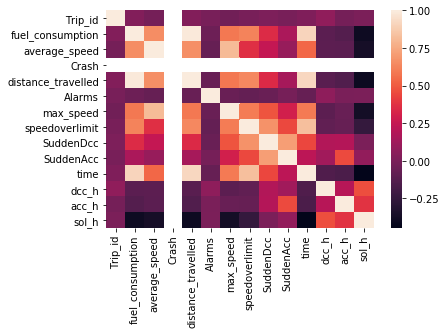

In [9]:
corr= df.corr()
sns.heatmap(corr)

As per Heatmap, Crash, Alarms and Trip id are independent of given data. 

From correlation values and implement a simple algorithm flow, only time, deccelaration, accelaration and speedoverlimit features will be considered for further process.

In [10]:
df.corr()

,Trip_id,fuel_consumption,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc,time,dcc_h,acc_h,sol_h
Trip_id,1.000000,0.032984,-0.012471,NaN,0.031928,-0.002358,-0.023999,-0.003277,0.016740,-0.002853,0.020626,0.075199,-0.015428,0.011008
fuel_consumption,0.032984,1.000000,0.657291,NaN,0.991121,-0.045252,0.587745,0.622714,0.351403,0.164768,0.910368,-0.104170,-0.125364,-0.390788
average_speed,-0.012471,0.657291,1.000000,NaN,0.661669,-0.067275,0.816906,0.370489,0.250290,0.100011,0.539248,-0.101614,-0.104413,-0.365157
Crash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance_travelled,0.031928,0.991121,0.661669,NaN,1.000000,-0.058183,0.589506,0.642641,0.346398,0.148513,0.926120,-0.110780,-0.138049,-0.399184
Alarms,-0.002358,-0.045252,-0.067275,NaN,-0.058183,1.000000,-0.051234,-0.073389,-0.051772,-0.009083,-0.064412,0.070508,0.003835,0.009670
max_speed,-0.023999,0.587745,0.816906,NaN,0.589506,-0.051234,1.000000,0.599470,0.480586,0.303521,0.597095,-0.096339,-0.059326,-0.368206
speedoverlimit,-0.003277,0.622714,0.370489,NaN,0.642641,-0.073389,0.599470,1.000000,0.675556,0.447785,0.830757,-0.079917,-0.064754,-0.248602
SuddenDcc,0.016740,0.351403,0.250290,NaN,0.346398,-0.051772,0.480586,0.675556,1.000000,0.716260,0.445508,0.188648,0.195465,0.009773
SuddenAcc,-0.002853,0.164768,0.100011,NaN,0.148513,-0.009083,0.303521,0.447785,0.716260,1.000000,0.224699,0.132419,0.454421,0.084507


In [11]:
df.head()

,Trip_id,fuel_consumption,total_time,average_speed,Crash,distance_travelled,Alarms,max_speed,speedoverlimit,SuddenDcc,SuddenAcc,time,dcc_h,acc_h,sol_h
0,1,1.633,0.43.37,30.494434,0,22676.0,0,118,184,4,1,0.722833,5.533779,1.383445,254.553839
1,2,0.284,0.14.10,18.058823,0,4000.0,0,60,77,3,1,0.235000,12.765957,4.255319,327.659574
2,3,0.088,0.02.33,18.087805,0,824.0,0,45,19,1,2,0.038833,25.751073,51.502146,489.270386
3,4,1.021,0.17.20,44.190735,0,13515.0,0,108,86,1,0,0.286667,3.488372,0.000000,300.000000
4,5,0.271,0.10.34,23.780981,0,4307.0,13,65,82,3,3,0.172333,17.408124,17.408124,475.822050


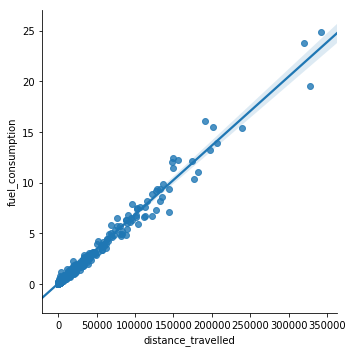

In [12]:
sns.lmplot(x='distance_travelled', y='fuel_consumption', data=df)

Efficient fuel consumption is observed from above graph

There are very few trips with more distance travelled. Since, time, fuel consumption and distance travelled are linearly proportional, all plots are not drawn.

And, any other metric related to fuel consumption and distance travelled are also proportional in such as time.


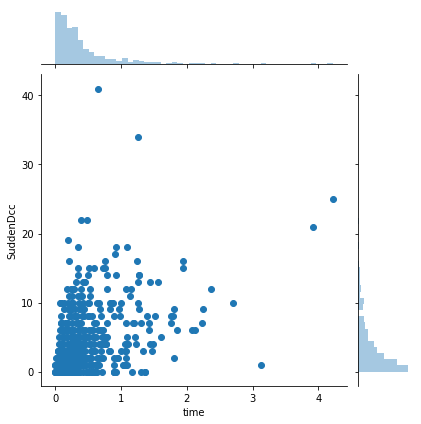

In [13]:
sns.jointplot(x='time', y='SuddenDcc', data=df)

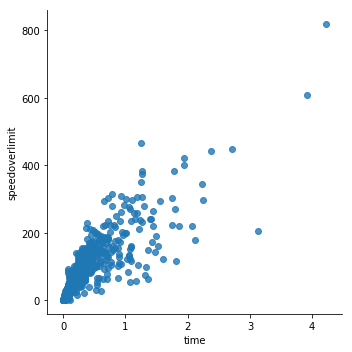

In [14]:
sns.lmplot(x='time', y='speedoverlimit', data=df, fit_reg=False)

From the above graphs, to compare a few, we can say that the trips which have more decelaration/acceleration between 0 to 2 hours are less efficient than those have decelation above 3 hours.

Thus, these explanation evidently visible when the SuddenDcc per trip is converted to probability of decelaration per hour, as the below chart

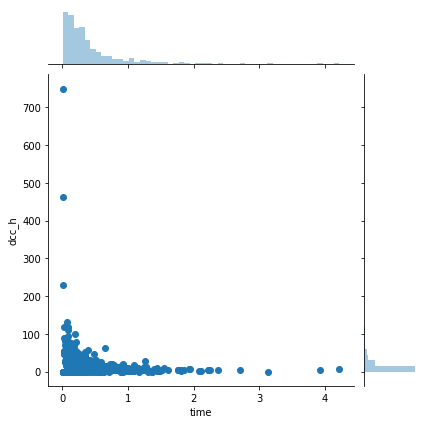

In [15]:
sns.jointplot(x='time', y='dcc_h', data=df)

In [16]:
df1 = df[['Trip_id','dcc_h','acc_h','sol_h']]
df1.head()

,Trip_id,dcc_h,acc_h,sol_h
0,1,5.533779,1.383445,254.553839
1,2,12.765957,4.255319,327.659574
2,3,25.751073,51.502146,489.270386
3,4,3.488372,0.000000,300.000000
4,5,17.408124,17.408124,475.822050


Features are Scaled and selected separately to form better clusters.

In [17]:
sdf1 = scale(df1)
sdf1 = pd.DataFrame(sdf1)
sdf1.head()

,0,1,2,3
0,-1.722072,-0.268585,-0.416972,-0.499044
1,-1.717311,-0.082709,-0.310273,-0.109614
2,-1.712549,0.251024,1.445095,0.751277
3,-1.707788,-0.321155,-0.468371,-0.256955
4,-1.703026,0.036600,0.178395,0.679638


In [18]:
feat_set1 = sdf1[[1,2]]     # dcc, acc
feat_set2 = sdf1[[2,3]]     # acc, sol

Optimal Combinations were selected based on a few trial and error methods:

K-Means Clustering is used to find the combinations of features which are relative to each other, to produce better scores.

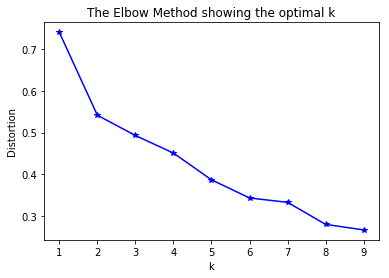

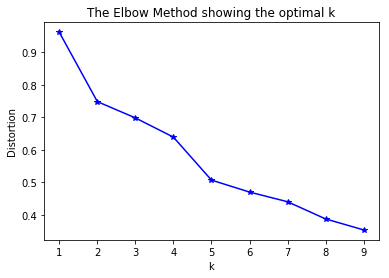

In [19]:
kmeans_cluster(feat_set1)
kmeans_cluster(feat_set2)

By the above method: Both feature sets shows 2 clusters as optimal value. 

silhouette score is calculated too to define the differences of clusters in a set.

In [20]:
kmeans1 = KMeans(n_clusters = 2, random_state = 42)
labels1 = kmeans1.fit_predict(feat_set1)

kmeans2 = KMeans(n_clusters = 2, random_state = 42)
labels2 = kmeans2.fit_predict(feat_set2)

In [21]:
silhouette_avg1 = silhouette_score(feat_set1,labels1)
print(silhouette_avg1)
silhouette_avg2 = silhouette_score(feat_set2,labels2)
print(silhouette_avg2)

0.7860890881469743
0.6406472989397808


Optional: Copying labels as clusters to the dataset. Since this is a regression problem, labels will not be used. 

considered features are scaled down to have range between 0 - 10

In [22]:
df1['group1'] = labels1
df1['group2'] = labels2

In [23]:
df1['dcc'] = scale_to_ten(df1['dcc_h'])
df1['acc'] = scale_to_ten(df1['acc_h'])
df1['sol'] = scale_to_ten(df1['sol_h'])

In [24]:
df1.head()

,Trip_id,dcc_h,acc_h,sol_h,group1,group2,dcc,acc,sol
0,1,5.533779,1.383445,254.553839,1,0,0.073784,0.041503,1.504709
1,2,12.765957,4.255319,327.659574,1,0,0.170213,0.127660,1.954159
2,3,25.751073,51.502146,489.270386,0,1,0.343348,1.545064,2.947734
3,4,3.488372,0.000000,300.000000,1,0,0.046512,0.000000,1.784110
4,5,17.408124,17.408124,475.822050,1,0,0.232108,0.522244,2.865054


In [25]:
df1['scr1'] = (df1.acc+df1.dcc)/2
df1['scr2'] = (df1.acc+df1.sol)/2

In [26]:
df1['score'] =10-((df1['scr1'] + df1['scr2'])/2)
df1.head()


,Trip_id,dcc_h,acc_h,sol_h,group1,group2,dcc,acc,sol,scr1,scr2,score
0,1,5.533779,1.383445,254.553839,1,0,0.073784,0.041503,1.504709,0.057644,0.773106,9.584625
1,2,12.765957,4.255319,327.659574,1,0,0.170213,0.127660,1.954159,0.148936,1.040909,9.405077
2,3,25.751073,51.502146,489.270386,0,1,0.343348,1.545064,2.947734,0.944206,2.246399,8.404698
3,4,3.488372,0.000000,300.000000,1,0,0.046512,0.000000,1.784110,0.023256,0.892055,9.542345
4,5,17.408124,17.408124,475.822050,1,0,0.232108,0.522244,2.865054,0.377176,1.693649,8.964588


In [27]:
max(df1['score'])

10.0

Now, that we have scores for each trip and will train a model to predict the target value, SVM is used for the purpose.

In [28]:
x = df1[['dcc_h','acc_h','sol_h']]
y = df1[['score']]

In [29]:
x_train, x_test,y_train, y_test = train_test_split(x, y, test_size=0.20)

In [30]:
y_train = le.fit_transform(y_train)

In [31]:
svc = svm.SVC(kernel='rbf', C=1.0)
svc.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [32]:
ypred = svc.predict(x_test)

In [33]:
inpred = le.inverse_transform(ypred)
max(inpred)

9.985699328156356

In [34]:
inpred

array([8.72008233, 9.65476907, 9.4903638 , 8.45589983, 9.6688553 ,
       9.36997797, 9.3056902 , 8.76805181, 9.30902994, 8.28736275,
       9.51519722, 9.66037935, 9.30014306, 8.81465108, 9.55711542,
       9.05858723, 9.05176056, 9.92683736, 9.76930466, 9.28362821,
       8.45578329, 8.51511268, 9.49896432, 9.94675799, 9.98569933,
       9.68713664, 8.87967087, 9.98569933, 9.46622305, 8.94109229,
       8.56368281, 8.45589983, 8.92524526, 9.39177789, 9.40649762,
       8.62630908, 9.41065588, 9.59126712, 8.99757283, 9.21074619,
       8.58681046, 9.06812312, 9.61929554, 9.39073015, 9.6064246 ,
       9.47658882, 8.96458758, 9.77249283, 9.38275931, 9.13485209,
       9.10613877, 9.66117604, 9.64797845, 9.57948489, 9.26249861,
       8.97549992, 9.83306794, 9.56149163, 9.45932346, 9.78884306,
       9.59885986, 9.13485209, 8.97484338, 8.61948347, 9.39491462,
       9.39400979, 9.67889253, 9.64632708, 9.41596478, 8.81465108,
       9.48462818, 9.75169932, 9.39491462, 9.42069977, 7.46399

inpred are the predicted scores for corresponding trips.

In [35]:
y_test = np.array(y_test)

Performance Metrics, which shows the residual errors between the predicted and actual score for a given trip.

In [36]:
MSE = mse(y_test,inpred)
MSE

0.310260657186483

In [37]:
RMSE = np.sqrt(MSE)
RMSE

0.5570104641624635

In [38]:
MAE = mae(y_test, inpred)
MAE

0.1186923593319383

In [39]:
r2_Score = r2(y_test,inpred)
r2_Score

0.3004915984815103

In [40]:
MAPE = mape(y_test,inpred)
MAPE

6.66364503761796

In [41]:
MPE = mpe(y_test, inpred)
MPE

1.685507533945273

3) Suggest any other metrics which can be devised for measuring driving behaviour.

Speed, Accelaration, Decelaration and trip time are the important to consider. 

Apart from those given, probably

Quick turns - right turns and left turns

Lane changes and traffic rules follow scores

phone handling

personal time take off in the given total trip time, these are the possibles I can think of.



In [45]:
res = x_test.copy()
res [ 'pred_score'] = inpred
res

,dcc_h,acc_h,sol_h,pred_score
32,81.818182,0.000000,654.545455,8.720082
566,4.485562,0.560695,215.306981,9.654769
24,12.552301,0.000000,291.841004,9.490364
616,49.586777,49.586777,481.700118,8.455900
407,5.354866,4.844879,155.036124,9.668855
282,16.375546,13.100437,284.934498,9.369978
287,0.000000,0.000000,456.140351,9.305690
428,41.933605,38.439138,384.391380,8.768052
272,12.332991,9.249743,379.239466,9.309030
362,56.749785,59.329321,588.134136,8.287363


In [46]:
count=0
a,b=[],[]
for i in df1.index:
    for j in res.index:
        if i == j:
            #print(df1.Trip_id[j],x_test.pred_score[j])
            t,s = df1.Trip_id[j],res.pred_score[j]
            a.append(t)
            b.append(s)

In [66]:
result = pd.DataFrame(index=range(len(a)))

In [67]:
result['Trip_id'] = a
result['Predicted_Score'] = b
result.head()

,Trip_id,Predicted_Score
0,6,9.498964
1,9,9.687137
2,17,9.300143
3,23,9.557115
4,25,9.490364


In [68]:
result = result.sort_values('Predicted_Score', ascending=False).reset_index(drop=True)
result

,Trip_id,Predicted_Score
0,708,9.985699
1,48,9.985699
2,194,9.985699
3,156,9.985699
4,589,9.946758
5,209,9.926837
6,326,9.858661
7,215,9.833068
8,360,9.833068
9,352,9.803044
